In [111]:
#fetch GFS data and plot at ENA
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import netCDF4
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from datetime import datetime, timedelta
from netCDF4 import num2date
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import tempfile
import os
import boto3

%matplotlib inline


In [123]:
import imp
lib_loc = os.path.join(os.path.expanduser('~'), 'projects/ACE-ENA-EVA/code/ena_tools.py')
ena_tools = imp.load_source('ena_tools', lib_loc)


/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [6]:
gra_lat = 39.0525
gra_lon = -28.0069
my_ncss = ena_tools.give_me_latest_gfs()

In [7]:
def get_me_grw_ths(ncss, varss):
    query = ncss.query()
    now = datetime.utcnow()
    gra_lat = 39.0525
    gra_lon = -28.0069
    query.lonlat_point(gra_lon, gra_lat).all_times()
    query.variables(*varss).accept('netcdf')
    data = ncss.get_data(query)
    return data


In [97]:
my_var = ['Temperature_isobaric', 'Relative_humidity_isobaric', 
          'Vertical_velocity_pressure_isobaric']
my_data = get_me_grw_ths(my_ncss, my_var)

In [98]:
my_data.variables.keys()

odict_keys(['isobaric3', 'Vertical_velocity_pressure_isobaric', 'isobaric', 'Relative_humidity_isobaric', 'Temperature_isobaric', 'station_name', 'station_description', 'latitude', 'longitude', 'time'])

In [100]:
my_data.variables['isobaric3'][:].squeeze()[0,:]

array([  10000.,   15000.,   20000.,   25000.,   30000.,   35000.,
         40000.,   45000.,   50000.,   55000.,   60000.,   65000.,
         70000.,   75000.,   80000.,   85000.,   90000.,   92500.,
         95000.,   97500.,  100000.], dtype=float32)

In [102]:
def ths(data_set, vert_var_bg = 'isobaric', vert_var_c = 'isobaric',
        pref_bg = u'T forecast (\u00b0C)',
        pref_c = 'Humdity (\%)',
             background_var = 'Temperature_isobaric',
              cont_var = 'Relative_humidity_isobaric',
             oset_1 = -273.15, scale_1 = 1.,
             vmin_1 = -80, vmax_1 = 25,
       clevs = [50,90,99], colors = ['r', 'b', 'k'],
       fmt = '%1.0f', con_size = 10):
    fig = plt.figure(figsize = [15,5])
    vert_bg = data_set.variables[vert_var_bg][:].squeeze()[0,:]/100
    vert_c = data_set.variables[vert_var_c][:].squeeze()[0,:]/100
    time = data_set.variables['time']
    datetimes = num2date(time[:].squeeze(), time.units)
    mapb = plt.pcolormesh(datetimes, vert_bg, 
                   scale_1 * data_set.variables[background_var][:].squeeze().transpose() + oset_1,
                         vmin = vmin_1,
                         vmax = vmax_1)
    con = plt.contour(datetimes, vert_c,
               data_set.variables[cont_var][:].squeeze().transpose(),
               levels = clevs, colors = colors)
    plt.clabel(con, inline=1, fontsize=con_size, fmt=fmt)
    plt.ylim([1000,0])
    time_val = datetimes[0]
    pref = pref_bg + ' and ' + pref_c
    plt.gca().set_title(pref + ' for {0:%d %B %Y %H:%MZ}'.format(time_val),
                 fontsize=10)
    plt.colorbar(mappable = mapb)
    
 

/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


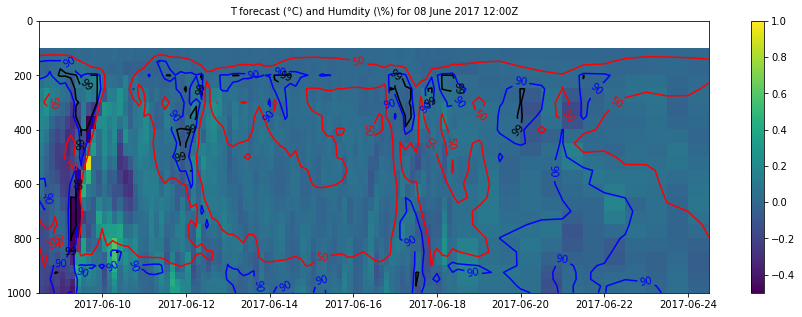

In [110]:
ths(my_data, vert_var_bg = 'isobaric3', 
    background_var = 'Vertical_velocity_pressure_isobaric',
   oset_1 = 0., scale_1 = 1.0,
   vmin_1 = -0.5, vmax_1 = 1)

In [106]:
print(my_data.variables['Vertical_velocity_pressure_isobaric'][:].max())

0.919


In [73]:
np.arange(1,10, 2)

array([1, 3, 5, 7, 9])

In [125]:
my_var = ['Temperature_isobaric', 'Relative_humidity_isobaric', 
          'Vertical_velocity_pressure_isobaric', 
         'Cloud_mixing_ratio_isobaric']
my_data = ena_tools.get_me_grw_ths(my_ncss, my_var)

/Users/scollis/anaconda/envs/houston/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


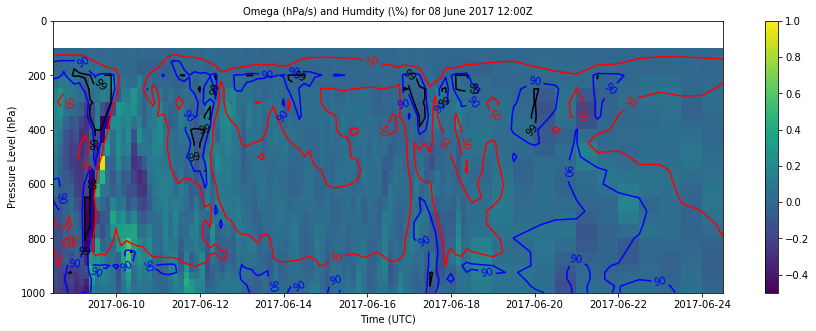

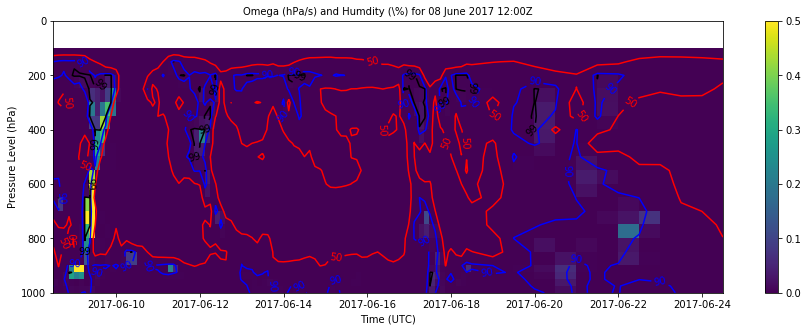

In [129]:
fig_datetime = ena_tools.ths(my_data, vert_var_bg = 'isobaric3', 
                             background_var = 'Vertical_velocity_pressure_isobaric',
                             oset_1 = 0., scale_1 = 1.0,
                             vmin_1 = -0.5, vmax_1 = 1,
                            pref_bg = u'Omega (hPa/s)')
local_fig =  tempfile.NamedTemporaryFile(suffix='.png')
fn = local_fig.name
plt.savefig(fn)
ena_tools.save_one_9pan('time_height_omega_rh', fn, fig_datetime)

fig_datetime = ena_tools.ths(my_data, vert_var_bg = 'isobaric3', 
                             background_var = 'Cloud_mixing_ratio_isobaric',
                             oset_1 = 0., scale_1 = 1000.0,
                             vmin_1 = 0, vmax_1 = 0.5,
                            pref_bg = u'Omega (hPa/s)')
local_fig =  tempfile.NamedTemporaryFile(suffix='.png')
fn = local_fig.name
plt.savefig(fn)
ena_tools.save_one_9pan('time_height_cld_rh', fn, fig_datetime)


In [127]:
print(my_data.variables['Cloud_mixing_ratio_isobaric'].units)

kg/kg
